## **About Dataset**
### **Context**

[Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning](http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5)

<figure>
<img src="jZqpV51.png">
<figcaption>Figure S6. Illustrative Examples of Chest X-Rays in Patients with Pneumonia, Related to Figure 6
The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.<br>
<a href="http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5">http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5</a></figcaption>
</figure>

### **Content**

- The dataset is organized into **3 folders (train, test, val)** and contains subfolders for each image category **(Pneumonia/Normal)**. There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

- Chest X-ray images **(anterior-posterior)** were selected from **retrospective cohorts** of **pediatric patients** of **one to five years old** from **Guangzhou Women and Children’s Medical Center, Guangzhou**. All chest X-ray imaging was **performed as part of patients’ routine clinical care**.

For the analysis of chest x-ray images, all chest radiographs were **initially screened** for quality control by **removing all low quality or unreadable scans**. The diagnoses for the images were then **graded by two expert physicians** before being cleared for training the AI system. **In order to account for any grading errors, the evaluation set was also checked by a third expert**.

### Acknowledgements
Data: [https://data.mendeley.com/datasets/rscbjbr9sj/2](https://data.mendeley.com/datasets/rscbjbr9sj/2)

License: [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)
Citation: [http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5](http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5)

<img src="8AUJkin.png">

### Inspiration
Automated methods to detect and classify human diseases from medical images.


## **What is Pneumonia?**

Pneumonia is a contagious airborne disease characterized by symptoms such as **cough**, **dyspnea** (breathlessness), **fever**, **tachypnea**, **chest pain**, and **fatigue**.

### Diagnosis

In addition to physical examination and serological tests, X-rays are commonly used to diagnose pneumonia.


> Each year, pneumonia claims the lives of over **725,000** children under the age of 5, including approximately **190,000** newborns.

In [57]:
import pathlib
import cv2
from sklearn.model_selection import train_test_split
import os
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import models, layers, optimizers, callbacks, metrics, regularizers
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, f1_score, recall_score, accuracy_score
from google.colab import drive
import zipfile
import seaborn as sns

In [ ]:
!pip install kaggle
drive.mount("/content/drive")
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/kaggle"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
with open("chest-xray-pneumonia.zip", "rb") as file:
  zipfile.ZipFile(file).extractall("/content/data")

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
def get_data(path):
    positive = path/"PNEUMONIA"
    negative = path/"NORMAL"
    im_positive_path = [*positive.glob("*.jpeg")]
    im_negative_path = [*negative.glob("*.jpeg")]
    im_path = im_positive_path + im_negative_path
    y = np.ones(len(im_path), dtype=int)
    y[len(im_positive_path):] = 0
    X = np.array([cv2.resize(cv2.imread(str(img), flags=cv2.IMREAD_GRAYSCALE),
    (256, 256)) for img in im_path])
    return X, y

root = pathlib.Path("/content/data/chest_xray")
train_path = root/"train"
test_path = root/"test"
val_path = root/"val"

X_train, y_train = get_data(train_path)
X_test, y_test = get_data(test_path)
X_val, y_val = get_data(val_path)

In [ ]:
class_names = ["Normal", "Pneumonia"]
class_counts = pd.Series(np.bincount(y_train)).rename("train").to_frame()\
.merge(pd.Series(np.bincount(y_val)).rename("validation"), right_index=True,
       left_index=True)\
.merge(pd.Series(np.bincount(y_test)).rename("test"), right_index=True,
       left_index=True)\
.rename(index={0:"normal", 1:"pneumonia"}).T

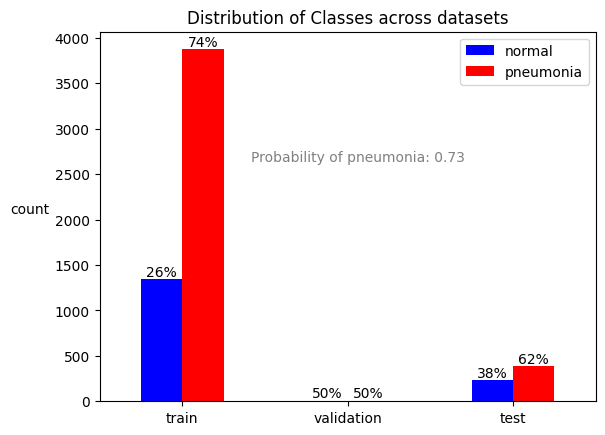

In [ ]:
ax=plt.subplot()
class_counts.plot(kind="bar", ax=ax, color=["blue", "red"])
percent = (class_counts.iloc[:, 0] / class_counts.sum(axis=1)).map("{:.0%}".format)
ax.bar_label(ax.containers[0], percent)
percent = (class_counts.iloc[:, 1] / class_counts.sum(axis=1)).map("{:.0%}".format)
ax.bar_label(ax.containers[1], percent)

total_percent = class_counts.loc[:, "pneumonia"].sum()/class_counts.sum().sum()
ax.annotate(text="Probability of pneumonia: {}".format(total_percent.round(2)), xy=(ax.get_xlim()[1]/6, ax.get_ylim()[1]*.65), color="gray")

ax.set_title("Distribution of Classes across datasets")
ax.tick_params(labelrotation=0)
ax.set_ylabel("count", rotation=0)
ax.axes.yaxis.label.set_ha("right")
plt.show()

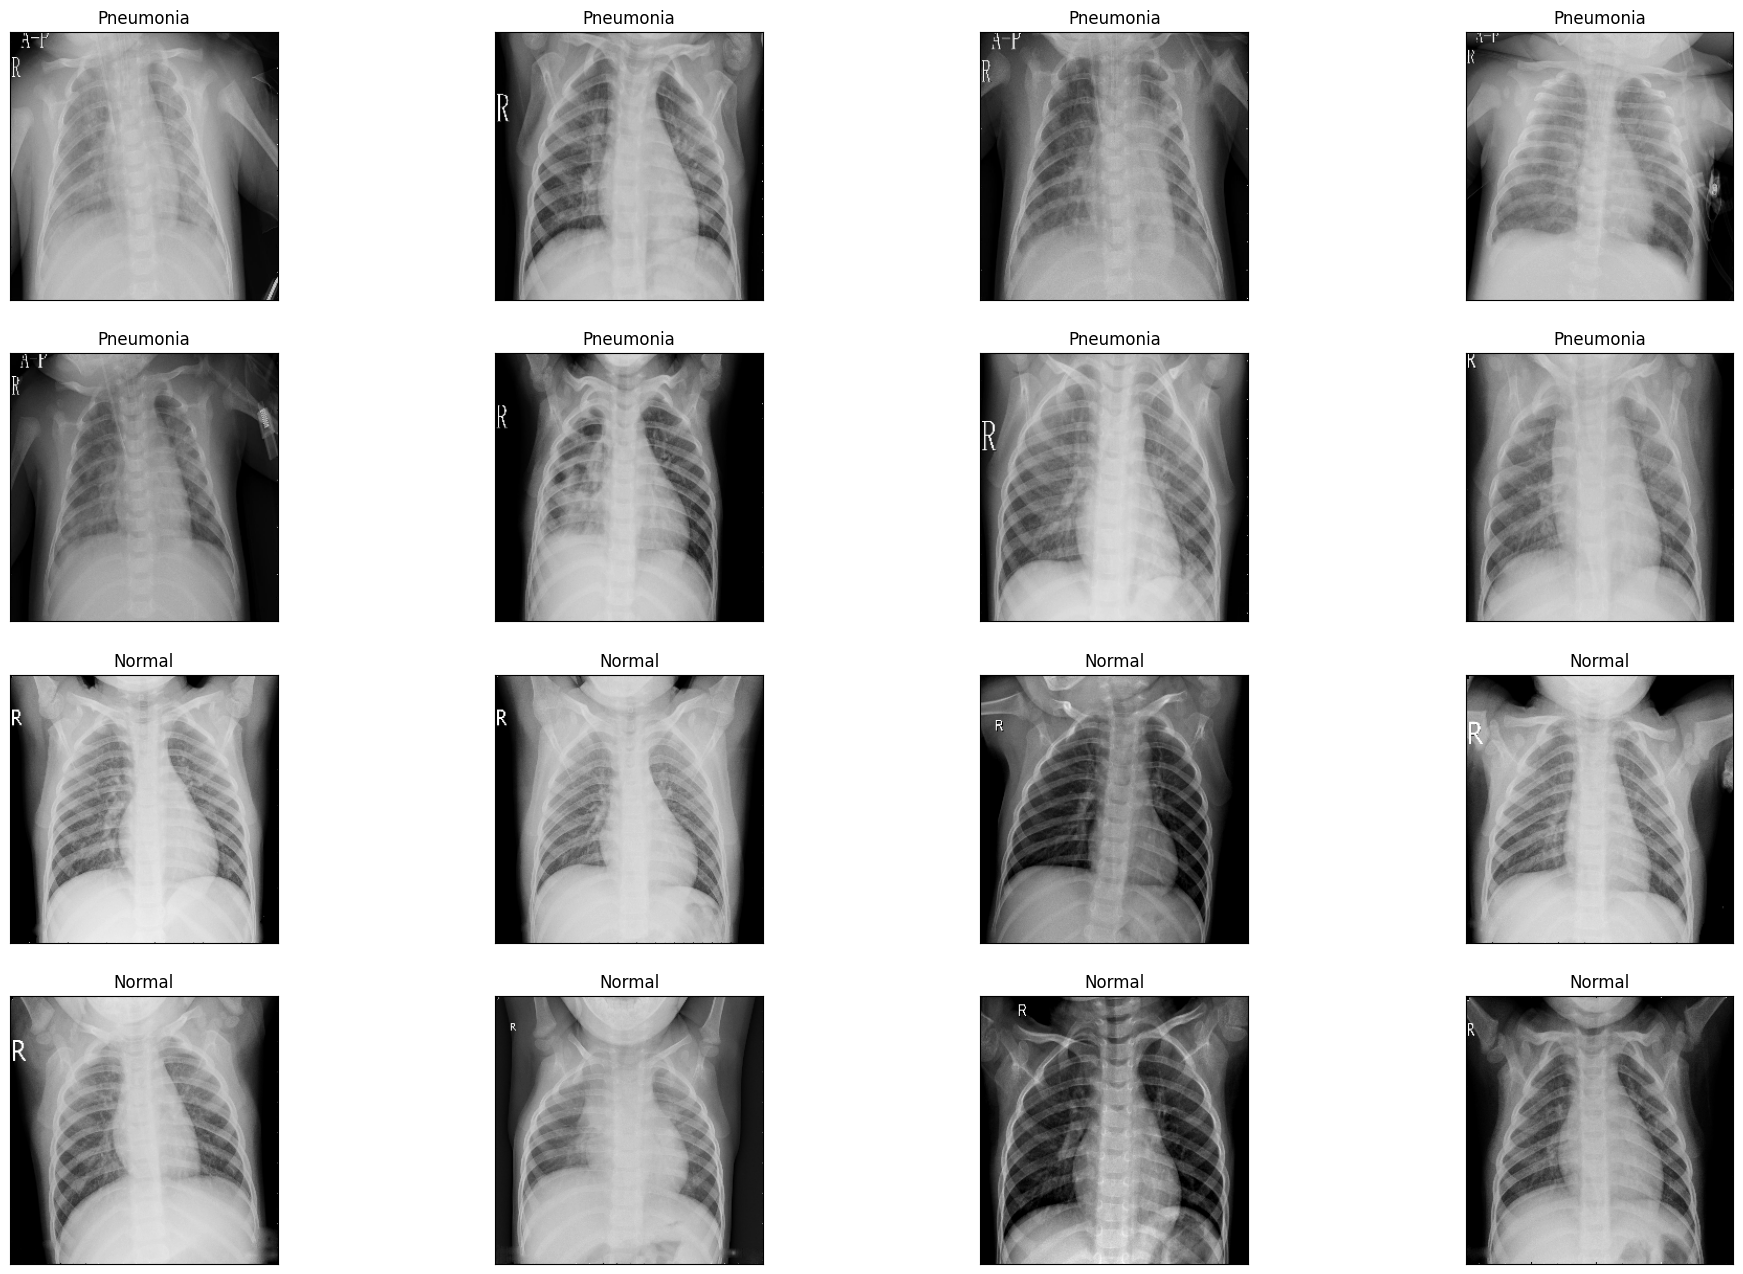

In [63]:
cols=4
rows=4
ax_width=6
ax_height=4
figure = plt.figure(figsize=(cols*ax_width, rows*ax_height))

for i in range(1, cols*rows+1):
    ax = plt.subplot(rows, cols, i)
    ax.imshow(X_val[i-1], cmap="gray")
    title = class_names[y_val[i-1]]
    ax.set_title(title)
    ax.set_xticks([],[])
    ax.set_yticks([],[])
    i+=1
plt.show()

- Some scans are easier to distinguish than others.

In [ ]:
model = models.Sequential(name="Xray")
model.add(layers.RandomFlip("horizontal", input_shape=(256, 256, 1)))
model.add(layers.RandomZoom(0.1))
model.add(layers.RandomBrightness(0.2))
model.add(layers.RandomContrast(0.2))
model.add(layers.RandomRotation(0.2))
model.add(layers.Rescaling(1/255))

model.add(layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Dropout(0.3))


model.add(layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Dropout(0.3))

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))


model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Xray"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_brightness (RandomBrightness) │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast (RandomContrast)     │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 256, 256, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 485,857 (1.85 MB)

 Trainable params: 484,961 (1.85 MB)

 Non-trainable params: 896 (3.50 KB)

In [9]:
optimizer = optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss="binary_crossentropy",
              metrics=["accuracy", metrics.Recall(name="recall"),
                       metrics.Precision(name="precision")])

early_stopping = callbacks.EarlyStopping(patience=10, monitor="val_loss",
                                         restore_best_weights=True)
lr_reduction = callbacks.ReduceLROnPlateau(patience=5, monitor="val_accuracy",
                                           factor=0.5, min_lr=1e-6)
with tf.device("/device:GPU:0"):
    hist = model.fit(X_train, y_train, shuffle=True, validation_data=(X_val, y_val),
                    epochs=50, callbacks=[early_stopping, lr_reduction])


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 376ms/step - accuracy: 0.7470 - loss: 3.8327 - precision: 0.8366 - recall: 0.8212 - val_accuracy: 0.5000 - val_loss: 5.4403 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 367ms/step - accuracy: 0.8644 - loss: 2.8697 - precision: 0.9216 - recall: 0.8904 - val_accuracy: 0.5000 - val_loss: 5.9321 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 372ms/step - accuracy: 0.8609 - loss: 2.2957 - precision: 0.9168 - recall: 0.8932 - val_accuracy: 0.5000 - val_loss: 5.8462 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 372ms/step - accuracy: 0.8782 - loss: 1.8519 - precision: 0.9405 - recall: 0.8911 - val_accuracy: 0.5000 - val_loss: 3.9492 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━

In [11]:
model.save("model.keras")

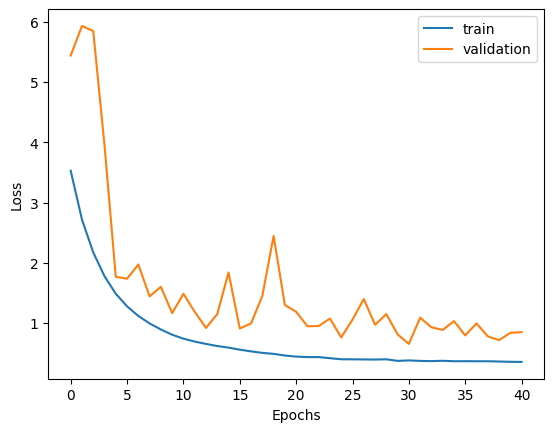

In [12]:
history = pd.DataFrame(hist.history)
plt.plot(history["loss"], label="train")
plt.plot(history["val_loss"], label="validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [13]:
with tf.device("/device:GPU:0"):
    preds_train = model.predict(X_train)
    preds_val = model.predict(X_val)
    preds_test = model.predict(X_test)

163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


In [14]:
class_report_train = classification_report(y_train, preds_train.round(), target_names=["Normal (Class 0)", "Pneumonia (Class 1)"], output_dict=True)
class_report_val = classification_report(y_val, preds_val.round(), target_names=["Normal (Class 0)", "Pneumonia (Class 1)"], output_dict=True)
class_report_test = classification_report(y_test, preds_test.round(), target_names=["Normal (Class 0)", "Pneumonia (Class 1)"], output_dict=True)

classification_reports = pd.DataFrame(class_report_train).T
columns = classification_reports.columns
classification_reports.columns=pd.Index([("train", col) for col in columns])

classification_reports = classification_reports\
.merge(pd.DataFrame(class_report_val).set_index(pd.Index([("validation", col) for col in columns])).T, left_index=True, right_index=True)\
.merge(pd.DataFrame(class_report_test).set_index(pd.Index([("test", col) for col in columns])).T, left_index=True, right_index=True)


In [15]:
display(classification_reports)

train                                  validation  \
                    precision    recall  f1-score      support  precision   
Normal (Class 0)     0.799754  0.970917  0.877063  1341.000000   0.857143   
Pneumonia (Class 1)  0.989130  0.915871  0.951092  3875.000000   0.777778   
accuracy             0.930023  0.930023  0.930023     0.930023   0.812500   
macro avg            0.894442  0.943394  0.914078  5216.000000   0.817460   
weighted avg         0.940443  0.930023  0.932060  5216.000000   0.817460   

                                                    test                      \
                     recall  f1-score  support precision    recall  f1-score   
Normal (Class 0)     0.7500  0.800000   8.0000  0.865672  0.743590  0.800000   
Pneumonia (Class 1)  0.8750  0.823529   8.0000  0.858156  0.930769  0.892989   
accuracy             0.8125  0.812500   0.8125  0.860577  0.860577  0.860577   
macro avg            0.8125  0.811765  16.0000  0.861914  0.837179  0.846494   
weighted avg         0.8125  0.811765  16.0000  0.860974  0.860577  0.858118   

                                 
                        support  
Normal (Class 0)     234.000000  
Pneumonia (Class 1)  390.000000  
accuracy               0.860577  
macro avg            624.000000  
weighted avg         624.000000

- **Overfitting Indication:** The model performs better on the test set than on the validation set, suggesting potential overfitting.
- **Recall Maximization:** Given the goal to maximize recall, the model shows good performance, particularly for the pneumonia class.

In [59]:
def get_threshold_metrics_for_recall(fpr, tpr, thresholds, y_true, preds,
                                     target_recall=1):
    recall_index = np.where(tpr >= target_recall)[0][0]
    best_threshold = thresholds[recall_index]
    best_fpr = fpr[recall_index]
    best_tpr = tpr[recall_index]
    preds_binary = (preds >= best_threshold).astype(int)
    precision_at_target_recall = precision_score(y_true, preds_binary)
    f1_at_target_recall = f1_score(y_true, preds_binary)
    return best_threshold, best_fpr, best_tpr, precision_at_target_recall, f1_at_target_recall

In [60]:
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, preds_val)

target_recall = 0.99
best_threshold_val, best_fpr_val, best_tpr_val, precision_val, f1_val =\
 get_threshold_metrics_for_recall(fpr_val, tpr_val, thresholds_val,
                                  y_val, preds_val, target_recall=0.99)


print(f"Best Threshold (Validation) = {best_threshold_val:.2f}")
print(f"Best False Positive Rate (Validation) = {best_fpr_val:.2f}")
print(f"Best True Positive Rate (Validation) = {best_tpr_val:.2f}")
print(f"Precision at 99% Recall (Validation) = {precision_val:.2f}")
print(f"F1 Score at 99% Recall (Validation) = {f1_val:.2f}")

Best Threshold (Validation) = 0.26
Best False Positive Rate (Validation) = 0.38
Best True Positive Rate (Validation) = 1.00
Precision at 99% Recall (Validation) = 0.73
F1 Score at 99% Recall (Validation) = 0.84


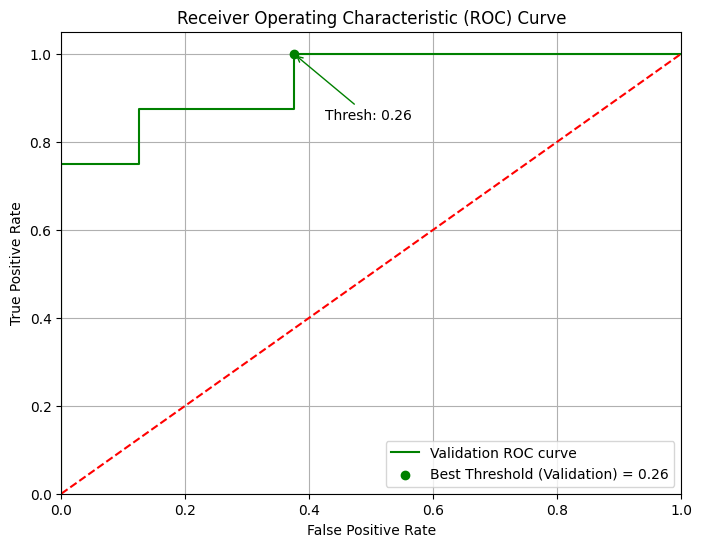

In [61]:
plt.figure(figsize=(8, 6))

plt.plot(fpr_val, tpr_val, color="green", label="Validation ROC curve")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.scatter(best_fpr_val, best_tpr_val, color="green", label="Best Threshold (Validation) = {:.2f}".format(best_threshold_val), zorder=5)
plt.annotate(f"Thresh: {best_threshold_val:.2f}", xy=(best_fpr_val, best_tpr_val), xytext=(best_fpr_val + 0.05, best_tpr_val - 0.15), arrowprops=dict(arrowstyle="->", color="green"), fontsize=10)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [62]:
preds_test_binary = (preds_test >= best_threshold_val).astype(int)

precision_test = precision_score(y_test, preds_test_binary)
recall_test = recall_score(y_test, preds_test_binary)
f1_test = f1_score(y_test, preds_test_binary)
accuracy_test = accuracy_score(y_test, preds_test_binary)


print(f"Precision at Best Threshold (Test) = {precision_test:.2f}")
print(f"Recall at Best Threshold (Test) = {recall_test:.2f}")
print(f"F1 Score at Best Threshold (Test) = {f1_test:.2f}")
print(f"Accuracy at Best Threshold (Test) = {accuracy_test:.2f}")

Precision at Best Threshold (Test) = 0.82
Recall at Best Threshold (Test) = 0.96
F1 Score at Best Threshold (Test) = 0.89
Accuracy at Best Threshold (Test) = 0.85


- The model performs well on the test set at the selected threshold of 0.26, effectively maximizing recall while maintaining strong precision and F1 scores. 
- Further tuning could focus on optimizing precision without significantly compromising recall.